In [2]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/code/')
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
# plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [9]:
# Load results of the fitting procedure

subject = 1
volume_space=True
semantic_discrim_type = 'all_coco_categ'
fitting_type = 'full_midlevel_plus_%s_plus_alexnet_best_layer_pca'%(semantic_discrim_type)

out= load_fits.load_fit_results(subject,fitting_type, n_from_end=0);
fig_save_folder=None

loading from /user_data/mmhender/imStat/model_fits/S01/full_midlevel_plus_all_coco_categ_plus_alexnet_best_layer_pca/Feb-15-2022_1358_03/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'semantic_feature_set', 'use_pca_st_feats', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn', 'alexnet_layer_name', 'alexnet_padding_mode', 'use_pca_alexnet_feats'])


In [17]:
out['voxel_subset_is_done_val']

array([ True,  True,  True,  True, False])

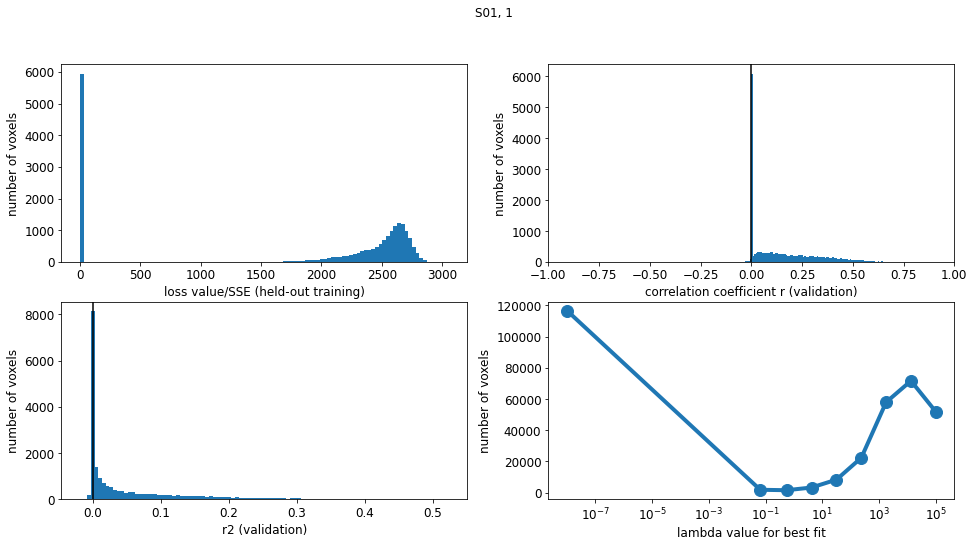

In [11]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, out, fig_save_folder=fig_save_folder)

In [13]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
roi_def = roi_utils.nsd_roi_def(subject)
skip_inds = [10,11,15,23]
# retlabs, facelabs, placelabs, bodylabs, \
#         ret_names, face_names, place_names, body_names = roi_def


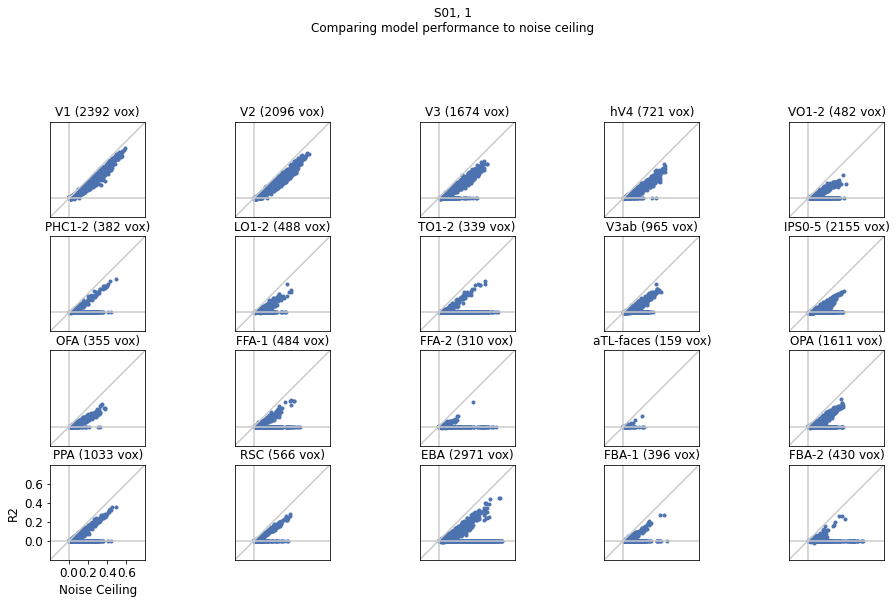

In [16]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(subject, out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder,axlims = [-0.2, 0.8])

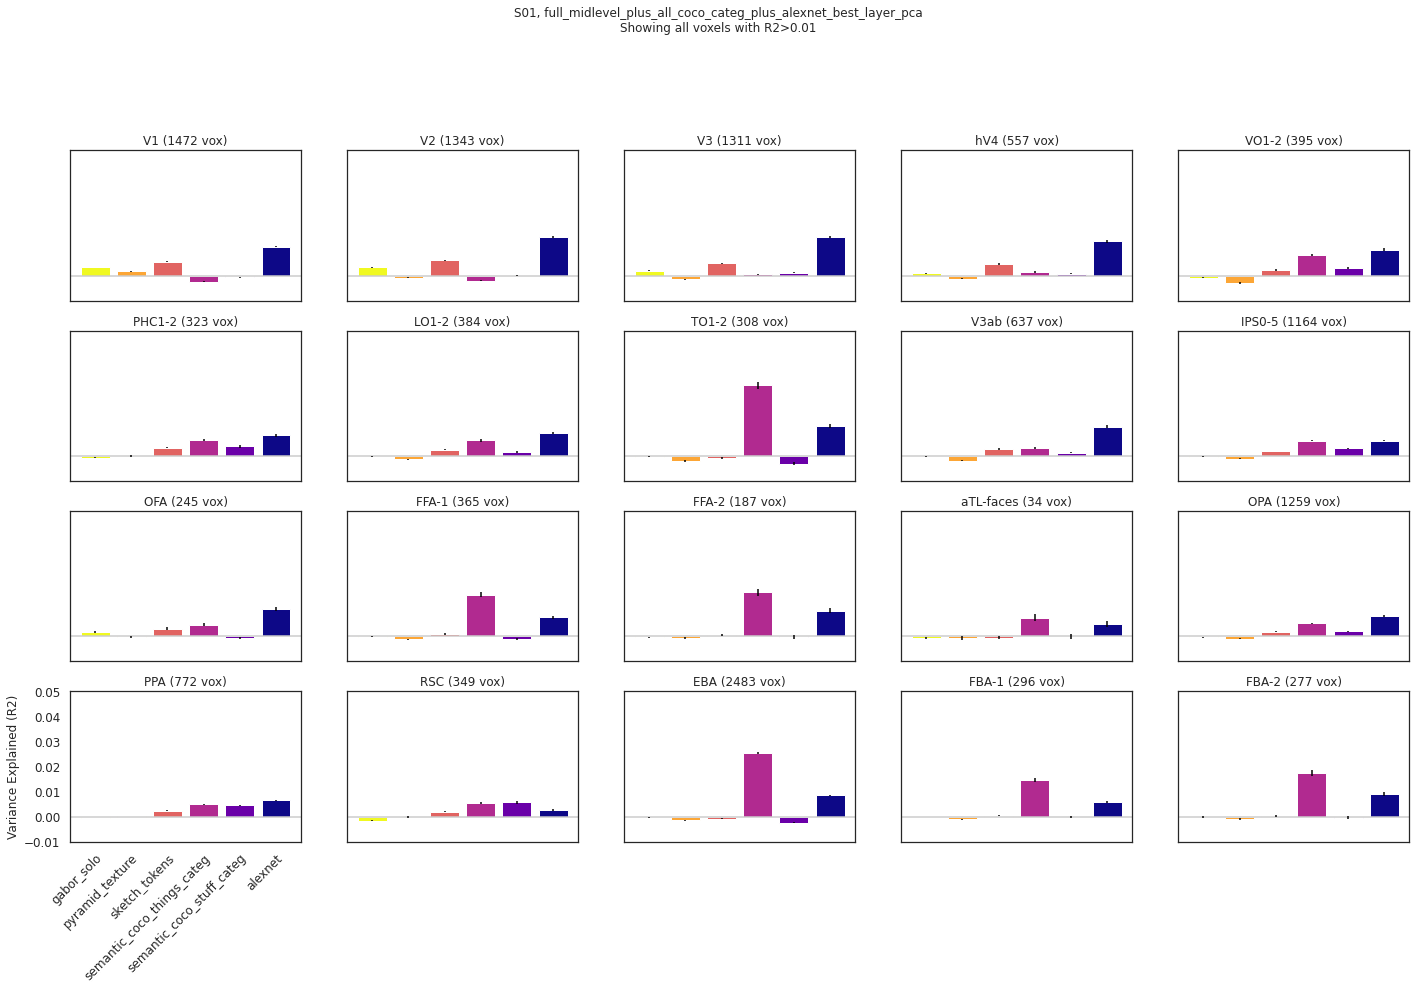

In [23]:
leave_out_inds = [2,4,10,12,14,16]
ve_names = [out['partial_version_names'][ll].split('leave_out_')[1] for ll in leave_out_inds]
var_expl = np.tile(out['val_r2'][:,0:1], [1,6]) - out['val_r2'][:,leave_out_inds]

colors = cm.plasma(np.linspace(0,1,len(leave_out_inds)))
colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)

In [34]:
from utils import stats_utils
from plotting import plot_prf_params

port=13333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity', 'pRF angle', \
         'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]
val_r2 = out['val_r2']

best_layer = out['best_layer_each_voxel']
names += ['best AlexNet layer (individual R2)', 'R2 best single layer alexnet fit']
maps += [(best_layer+1).astype(np.float32),np.sqrt(val_r2[:,13])]
cmaps += ['plasma_r', 'PuBu']
mins += [0, 0]
maxes += [5, 0.8]

pp0 = 0
pp1 = 16
pp2 = 15
val_r2 = out['val_r2']
name1 = 'midlevel+%s'%semantic_discrim_type
name2 = 'alexnet'
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+2).astype(np.float32)
max_ind[max_ind==2] = 1.5

# max_ind[bad_voxels] = np.nan

maps += [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names  += ['Concat model','Unique var: %s'%name1, 'Unique var: %s'%name2, 'Shared variance', \
          'Unique var greater for %s or %s'%(name1, name2)]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 3]

vox2plot = val_r2[:,0]>=0

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type='%s + %s'%(name1, name2), \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:13333
Started server on port 13333


In [26]:
out['partial_version_names']

['full_combined_model',
 'just_gabor_solo',
 'leave_out_gabor_solo',
 'just_pyramid_texture',
 'leave_out_pyramid_texture',
 'pyramid_texture_just_lower-level_no_other_modules',
 'pyramid_texture_just_higher-level_no_other_modules',
 'pyramid_texture_just_lower-level_plus_other_modules',
 'pyramid_texture_just_higher-level_plus_other_modules',
 'just_sketch_tokens',
 'leave_out_sketch_tokens',
 'just_semantic_coco_things_categ',
 'leave_out_semantic_coco_things_categ',
 'just_semantic_coco_stuff_categ',
 'leave_out_semantic_coco_stuff_categ',
 'just_alexnet',
 'leave_out_alexnet']

['full_combined_model', 'leave_out_alexnet', 'just_alexnet']


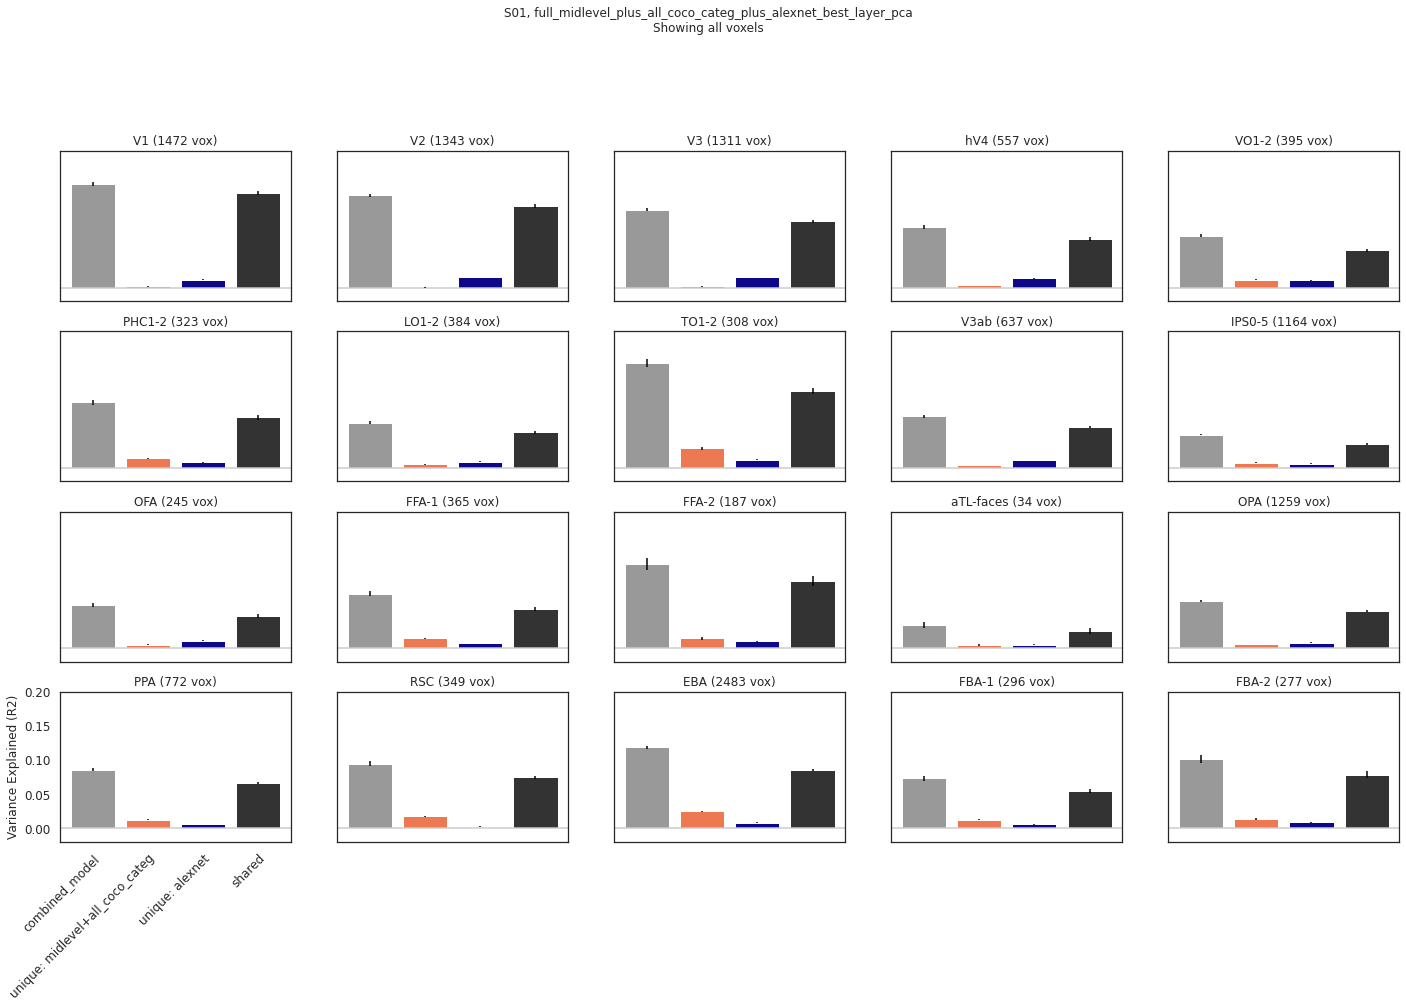

In [32]:
pp0 = 0
pp1 = 16
pp2 = 15
print([out['partial_version_names'][pp] for pp in [pp0, pp1, pp2]])

# for each voxel, choosing which fits to use based on its best layer
val_r2 = out['val_r2']

name1 = 'midlevel+%s'%semantic_discrim_type

name2 = 'alexnet'

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)


['full_combined_model', 'leave_out_alexnet', 'just_alexnet']


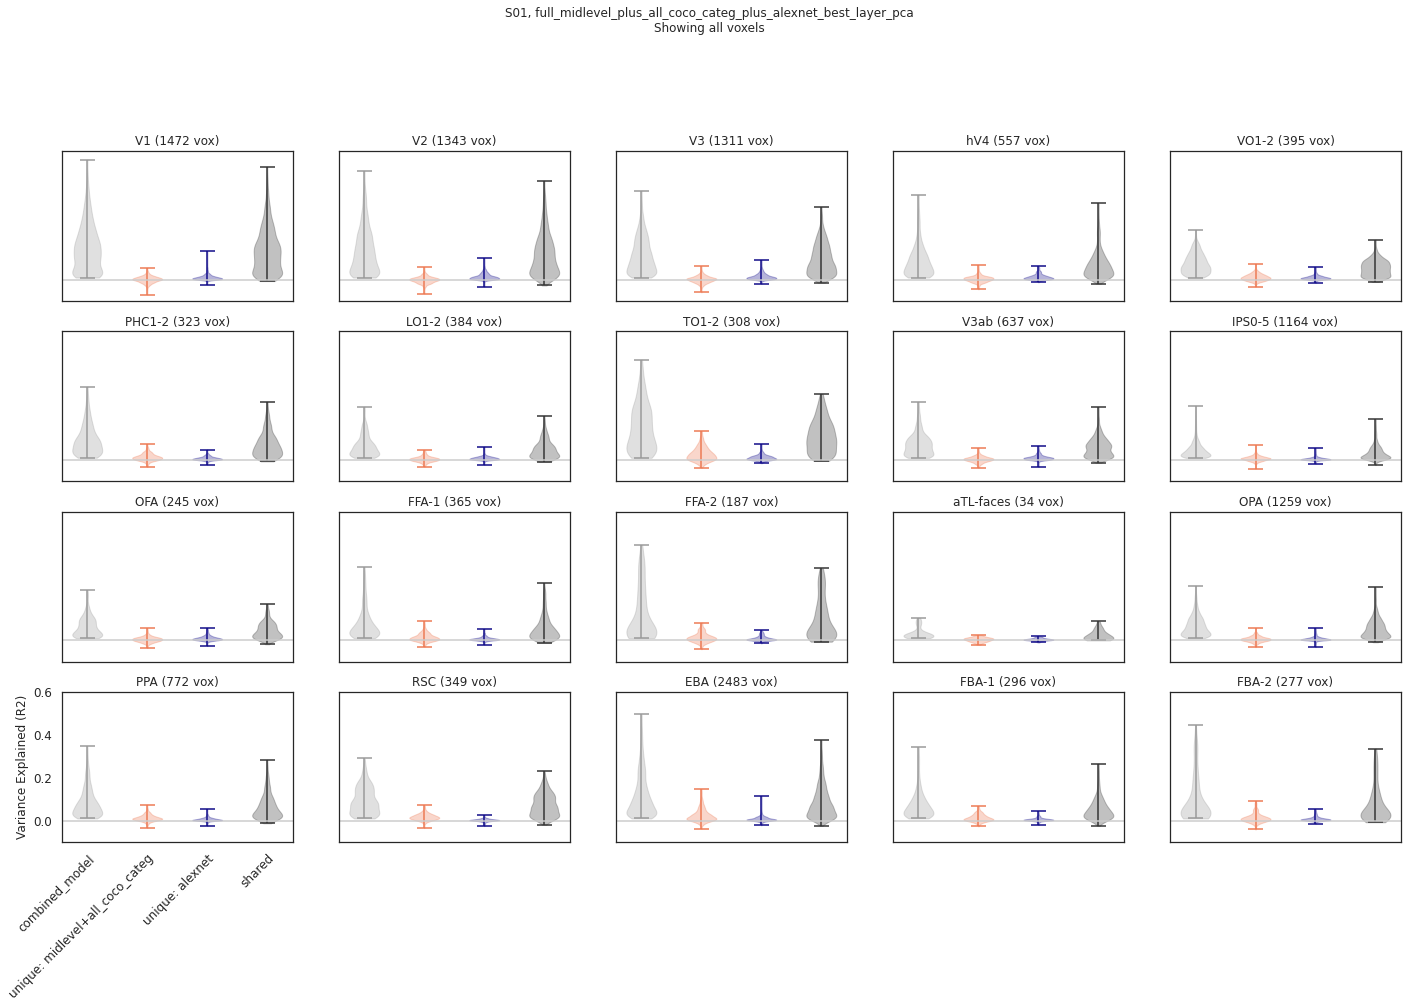

In [33]:
pp0 = 0
pp1 = 16
pp2 = 15
print([out['partial_version_names'][pp] for pp in [pp0, pp1, pp2]])

# for each voxel, choosing which fits to use based on its best layer
val_r2 = out['val_r2']

name1 = 'midlevel+%s'%semantic_discrim_type

name2 = 'alexnet'

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.pdf'))
#     plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.png'))